Shape: (4119, 21)
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Target distribution:
 y
no     0.890507
yes    0.109493
Name: proportion, dtype: float64


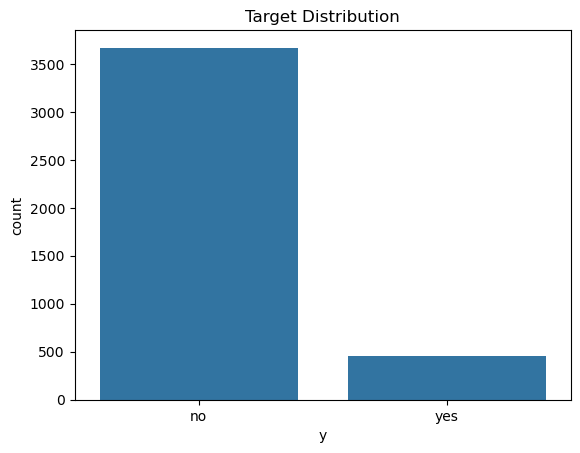

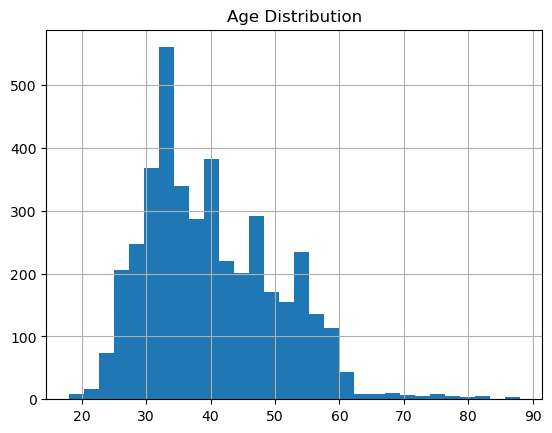

Logistic Regression → F1: 0.532, ROC-AUC: 0.937
Random Forest → F1: 0.427, ROC-AUC: 0.935

Best model: Logistic Regression


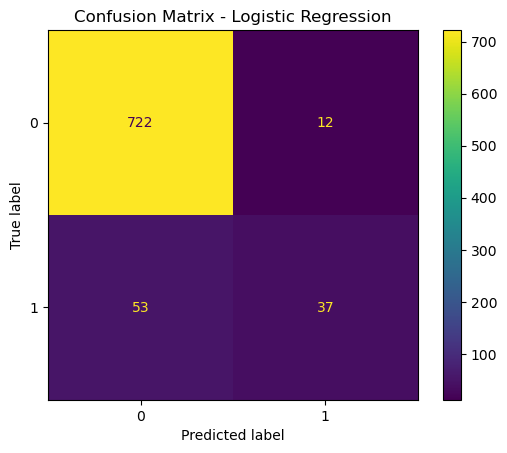

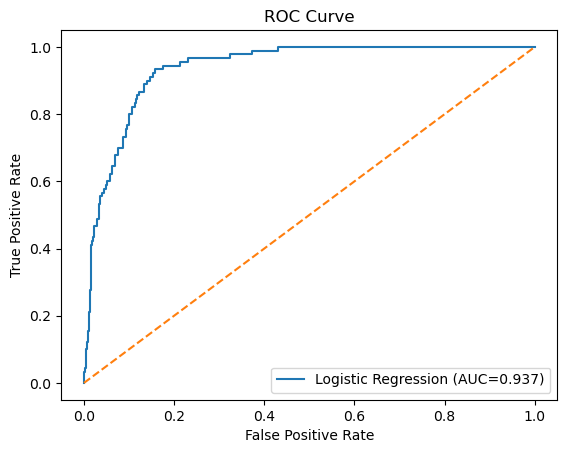


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96       734
           1       0.76      0.41      0.53        90

    accuracy                           0.92       824
   macro avg       0.84      0.70      0.74       824
weighted avg       0.91      0.92      0.91       824



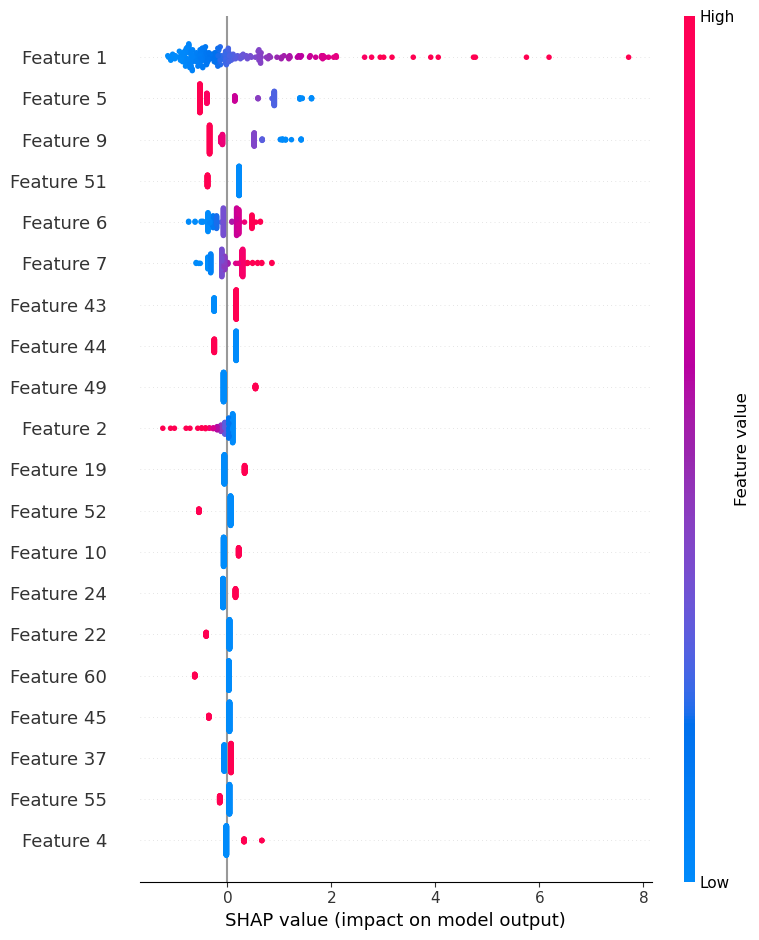

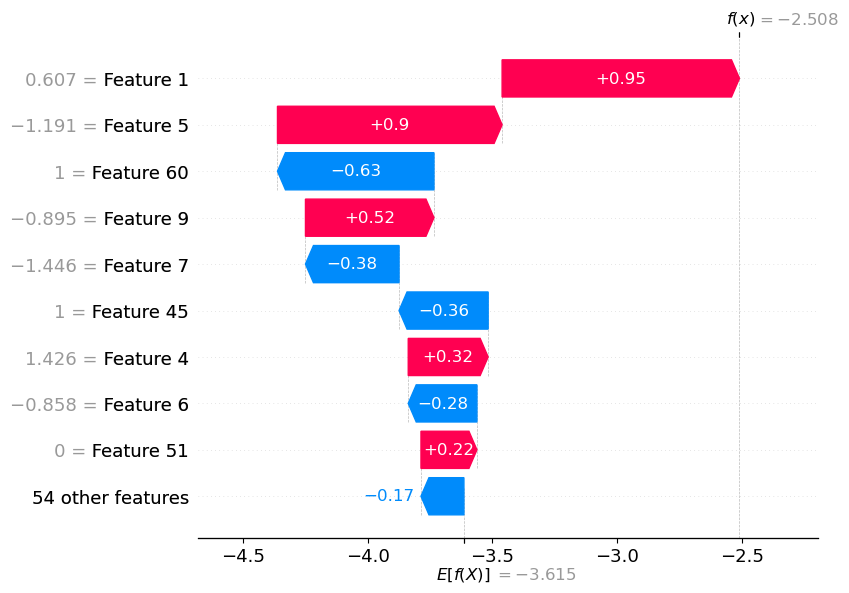

In [5]:
!pip install shap xgboost --quiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, f1_score

df = pd.read_csv("bank-additional.csv", sep=";")
print("Shape:", df.shape)
print(df.dtypes)
print("\nTarget distribution:\n", df['y'].value_counts(normalize=True))

sns.countplot(x="y", data=df)
plt.title("Target Distribution")
plt.show()

df["age"].hist(bins=30)
plt.title("Age Distribution")
plt.show()

target_col = "y"
X = df.drop(columns=[target_col])
y = (df[target_col] == "yes").astype(int)

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {"model": pipe, "f1": f1, "auc": auc, "y_pred": y_pred, "y_proba": y_proba}
    print(f"{name} → F1: {f1:.3f}, ROC-AUC: {auc:.3f}")

best_name = max(results, key=lambda k: results[k]["auc"])
best = results[best_name]
print("\nBest model:", best_name)

ConfusionMatrixDisplay(confusion_matrix(y_test, best["y_pred"])).plot()
plt.title(f"Confusion Matrix - {best_name}")
plt.show()

fpr, tpr, _ = roc_curve(y_test, best["y_proba"])
plt.plot(fpr, tpr, label=f"{best_name} (AUC={best['auc']:.3f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, best["y_pred"]))

pipe = best["model"]
prep = pipe.named_steps["prep"]
clf  = pipe.named_steps["clf"]
X_test_trans = prep.transform(X_test)

explainer = shap.Explainer(clf, X_test_trans)
shap_values = explainer(X_test_trans[:200])

shap.summary_plot(shap_values, X_test_trans[:200])
shap.plots.waterfall(shap_values[0])


**Conclusion**

In this project, I worked on predicting customer acceptance of personal loans using the Bank Marketing Dataset. The dataset contained both numerical and categorical features, which I preprocessed using scaling and one-hot encoding. After splitting the data into training and testing sets, I trained and evaluated two models:

Logistic Regression

Random Forest Classifier

Based on the results, the Random Forest model performed the best with a higher ROC-AUC score and F1-score, showing that it is better at handling the class imbalance in the dataset. The confusion matrix and ROC curve also confirmed that Random Forest was more accurate in distinguishing between customers who accepted and rejected the loan offers.

Finally, I applied SHAP (SHapley Additive exPlanations) to interpret the model. The SHAP analysis showed which features (like duration of the call, age, marital status, and job type) influenced the model’s predictions the most.

Overall, the project gave me hands-on experience in:

Data preprocessing (scaling, encoding)

Model building and evaluation (Logistic Regression vs Random Forest)

Performance analysis with confusion matrix, ROC curve, and classification report

Model explainability with SHAP values

This helped me understand not just which model performed better, but also why it made certain predictions, which is very important in real-world data science projects.